In [1]:
import numpy as np
import cv2
import h5py


from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend
import tensorflow as tf


import string
import matplotlib.pyplot as plt

2023-04-09 11:19:29.665689: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/fizzer/.local/lib/python3.8/site-packages/cv2/../../lib64:/opt/ros/noetic/lib
2023-04-09 11:19:29.665705: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [15]:
raw_imgs1 = np.load('/home/fizzer/ros_ws/src/controller_pkg/cnn_trainer/plates/imgs.npy')
raw_labels1 = np.load('/home/fizzer/ros_ws/src/controller_pkg/cnn_trainer/plates/labels.npy')
raw_imgs2 = np.load('/home/fizzer/ros_ws/src/controller_pkg/cnn_trainer/plates/imgs1.npy')
raw_labels2 = np.load('/home/fizzer/ros_ws/src/controller_pkg/cnn_trainer/plates/labels1.npy')
raw_imgs=np.concatenate([raw_imgs1, raw_imgs2])
raw_labels=np.concatenate([raw_labels1, raw_labels2])
print(raw_imgs.shape)
print(raw_labels.shape)

(36000, 150, 100)
(36000,)


T
(150, 100)


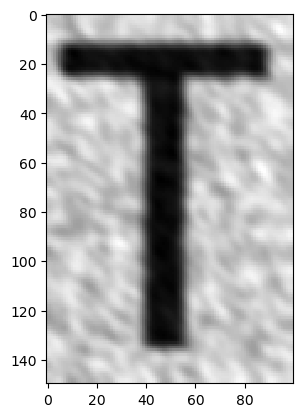

In [16]:
p = np.random.permutation(36000)
raw_imgs=raw_imgs[p]
raw_labels=raw_labels[p]
print(raw_labels[10])
print(raw_imgs[10].shape)
plt.imshow(raw_imgs[10], cmap='gray')

In [17]:
keys=list(string.ascii_uppercase+'0123456789')
values = list(np.arange(0,36))
labels_to_int = dict(zip(keys, values))
int_to_labels = dict(zip(values, keys))
labels=np.array([labels_to_int[l] for l in raw_labels])
labels

array([12, 10, 30, ...,  2, 16,  1])

In [6]:
imgs = raw_imgs/255
imgs=imgs[...,np.newaxis]

In [7]:
print(imgs.shape)
print(labels.shape)

(36000, 150, 100, 1)
(36000,)


In [8]:


# Commented out a bunch of the layers because our model can be much simpler.

conv_model = models.Sequential()
conv_model.add(layers.Conv2D(2, (8, 8), strides=4,activation='relu',
                             input_shape=(150, 100,1)))
conv_model.add(layers.MaxPooling2D((4, 4)))
# conv_model.add(layers.Conv2D(16, (3, 3), activation='relu'))
# conv_model.add(layers.MaxPooling2D((4, 4)))
# conv_model.add(layrs.Conv2D(128, (3, 3), activation='relu'))
# conv_model.add(layers.MaxPooling2D((2, 2)))
# conv_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Flatten())
conv_model.add(layers.Dropout(0.5))
# conv_model.add(layers.Dense(64, activation='relu'))
conv_model.add(layers.Dense(36, activation='softmax'))

conv_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 36, 24, 2)         130       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 6, 2)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 108)               0         
                                                                 
 dropout (Dropout)           (None, 108)               0         
                                                                 
 dense (Dense)               (None, 36)                3924      
                                                                 
Total params: 4,054
Trainable params: 4,054
Non-trainable params: 0
______________________________________________________

2023-04-08 22:28:52.377796: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/fizzer/.local/lib/python3.8/site-packages/cv2/../../lib64:/opt/ros/noetic/lib
2023-04-08 22:28:52.377822: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-08 22:28:52.377842: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (skynet): /proc/driver/nvidia/version does not exist
2023-04-08 22:28:52.378061: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:


# Used sparse categorical crossentropy so because it automatically performs one-hot-encoding
# So that we don't have to do it ourselves.

LEARNING_RATE = 1e-4
conv_model.compile(loss='sparse_categorical_crossentropy',
                   optimizer=optimizers.RMSprop(learning_rate=LEARNING_RATE),
                   metrics=['acc'])



In [10]:


history_conv = conv_model.fit(imgs, labels, 
                              validation_split=0.2, 
                              epochs=10, 
                              batch_size=4)



Epoch 1/10


2023-04-08 22:28:55.375700: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1728000000 exceeds 10% of free system memory.


7199/7200 [============================>.] - ETA: 0s - loss: 3.0288 - acc: 0.2314

2023-04-08 22:29:06.850122: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 432000000 exceeds 10% of free system memory.


7200/7200 [==============================] - 12s 2ms/step - loss: 3.0287 - acc: 0.2314 - val_loss: 1.5779 - val_acc: 0.8743
Epoch 2/10
7200/7200 [==============================] - 11s 2ms/step - loss: 1.0899 - acc: 0.7300 - val_loss: 0.2583 - val_acc: 0.9958
Epoch 3/10
7200/7200 [==============================] - 11s 2ms/step - loss: 0.4386 - acc: 0.8816 - val_loss: 0.0848 - val_acc: 0.9976
Epoch 4/10
7200/7200 [==============================] - 12s 2ms/step - loss: 0.2532 - acc: 0.9289 - val_loss: 0.0402 - val_acc: 0.9983
Epoch 5/10
7200/7200 [==============================] - 11s 2ms/step - loss: 0.1711 - acc: 0.9515 - val_loss: 0.0235 - val_acc: 0.9987
Epoch 6/10
7200/7200 [==============================] - 11s 2ms/step - loss: 0.1291 - acc: 0.9619 - val_loss: 0.0144 - val_acc: 0.9990
Epoch 7/10
7200/7200 [==============================] - 11s 2ms/step - loss: 0.1025 - acc: 0.9702 - val_loss: 0.0103 - val_acc: 0.9989
Epoch 8/10
7200/7200 [==============================] - 12s 2ms/st

In [11]:
plate_syms = np.load('/home/fizzer/ros_ws/src/controller_pkg/cnn_trainer/data/plate_symbols.npy', allow_pickle=True)
print(plate_syms.shape)
plate_syms = plate_syms.reshape(156, 150, 100)
pred_syms = plate_syms[...,np.newaxis]
print(pred_syms.shape)

(39, 4, 150, 100)
(156, 150, 100, 1)


In [12]:
pred_syms=pred_syms/255
pred = conv_model.predict(pred_syms)
pred

5/5 [==============================] - 0s 2ms/step


array([[2.2287176e-04, 7.9673338e-01, 1.2210083e-04, ..., 2.1589765e-05,
        1.1334880e-01, 3.4075943e-03],
       [3.5715591e-05, 1.2538506e-04, 8.7060183e-01, ..., 1.4734285e-05,
        1.0048379e-03, 1.7211081e-05],
       [3.2945140e-05, 3.4230350e-05, 8.5048305e-05, ..., 2.6911832e-04,
        4.4877165e-06, 1.4542899e-04],
       ...,
       [6.2194260e-05, 5.6763284e-04, 1.2611368e-03, ..., 2.4417974e-03,
        2.6745145e-04, 2.2946942e-05],
       [9.3498947e-03, 5.1149953e-05, 6.6758633e-07, ..., 1.9705615e-06,
        4.1164469e-05, 3.4212032e-06],
       [1.3326613e-03, 1.7782429e-04, 4.1888002e-04, ..., 4.7068450e-01,
        1.5341931e-04, 1.0791067e-03]], dtype=float32)

B
0.7967334


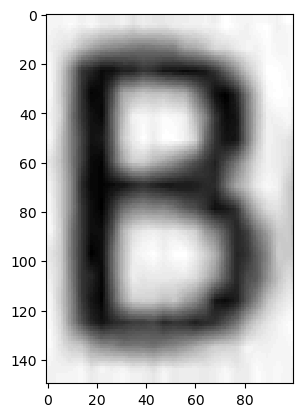

C
0.87060183


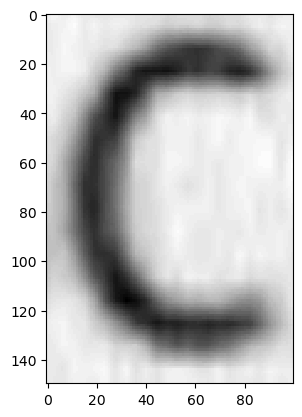

1
0.94516826


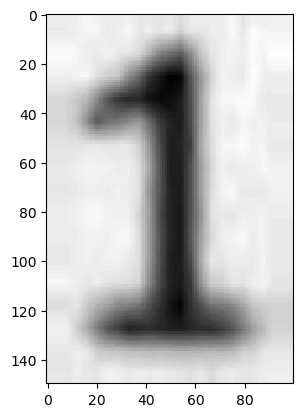

8
0.8742868


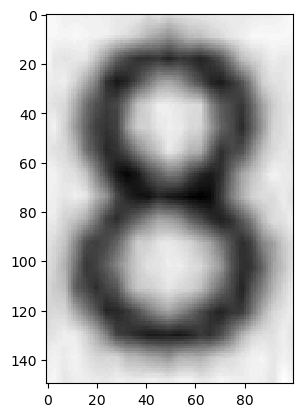

B
0.9345349


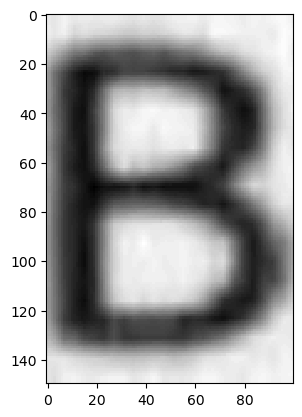

C
0.91664165


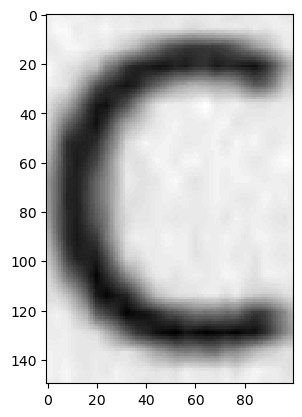

1
0.99232787


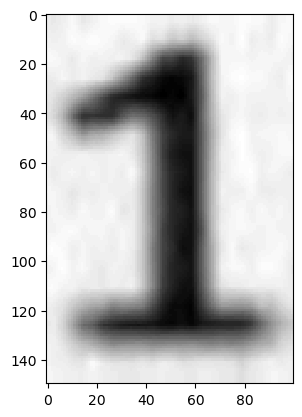

T
0.5099366


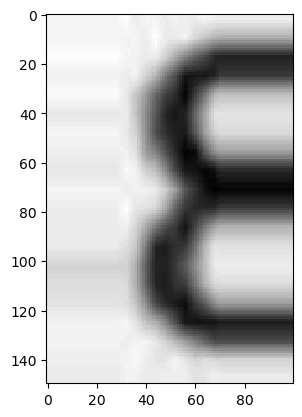

K
0.8976066


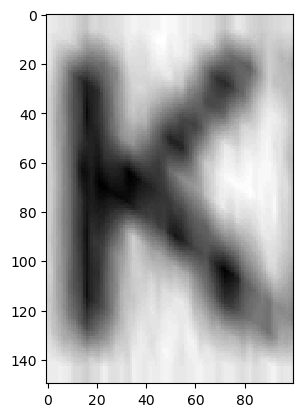

R
0.29737607


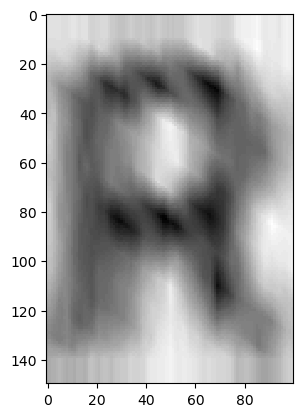

4
0.92564154


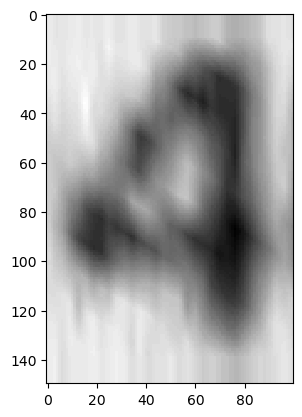

O
0.405351


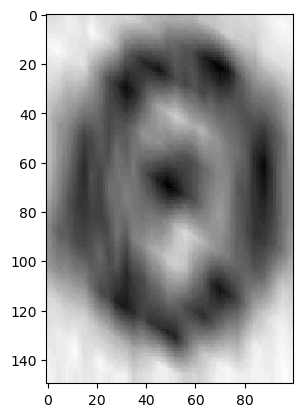

K
0.89452016


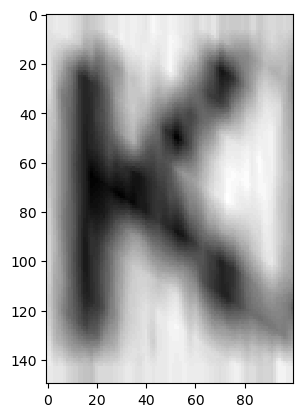

R
0.2769258


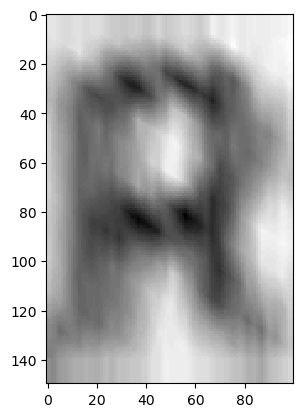

4
0.9199509


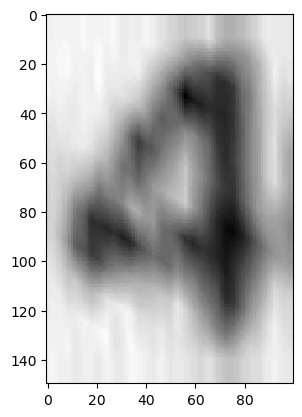

O
0.28578773


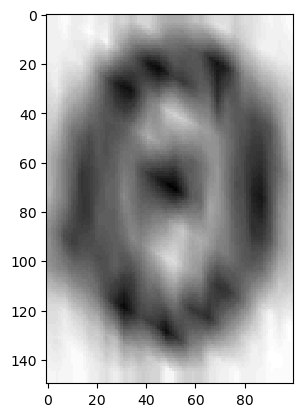

K
0.90490437


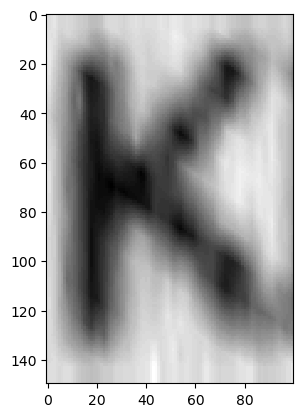

R
0.25832558


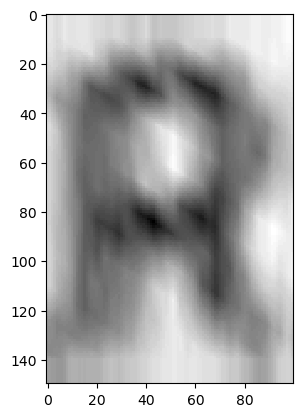

4
0.91476667


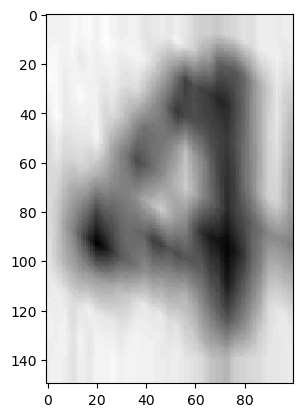

0
0.28565693


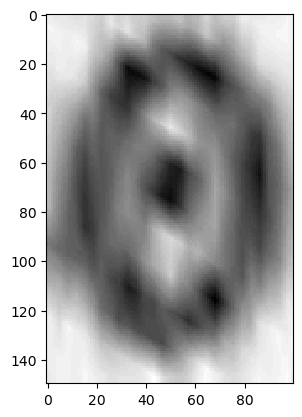

K
0.9046246


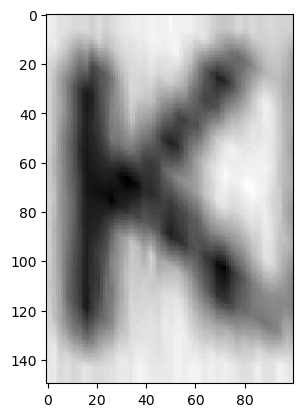

R
0.32523718


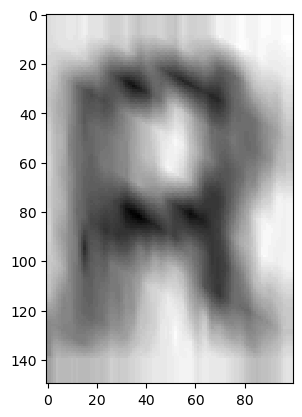

4
0.9401536


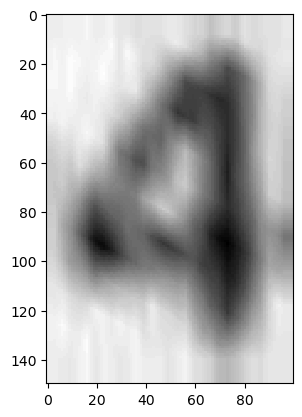

0
0.28186628


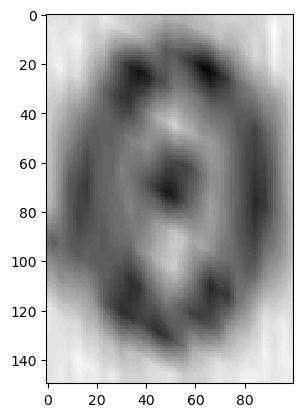

K
0.90886873


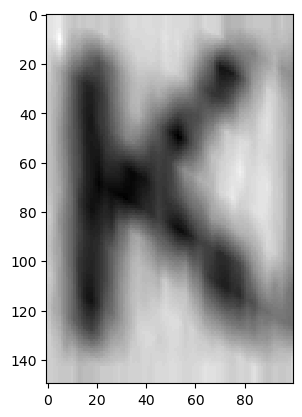

R
0.38918343


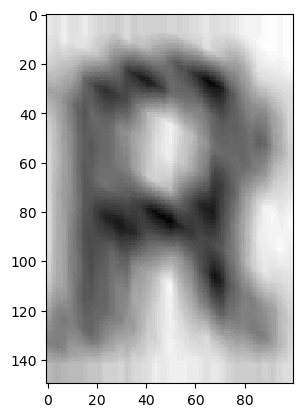

4
0.9151571


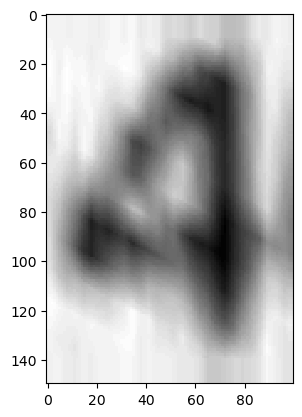

0
0.3770428


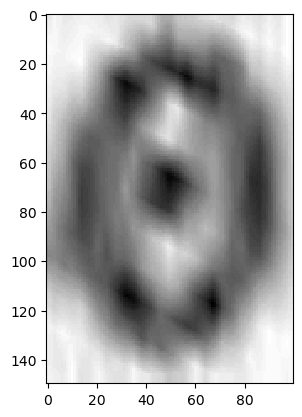

K
0.90773475


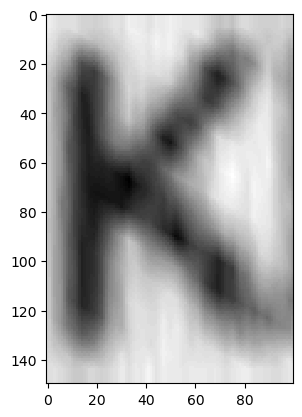

R
0.44268504


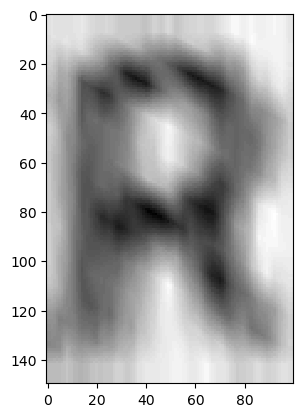

4
0.9460417


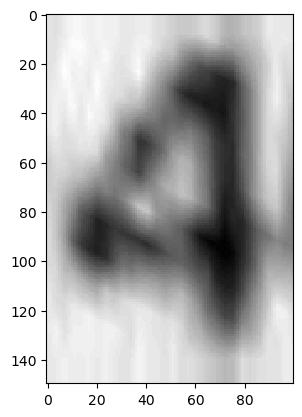

0
0.40289322


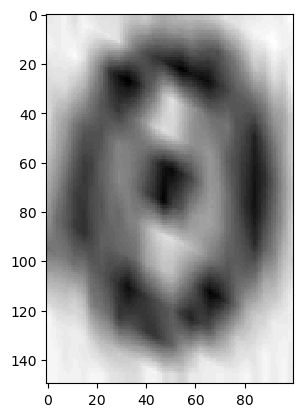

K
0.9287241


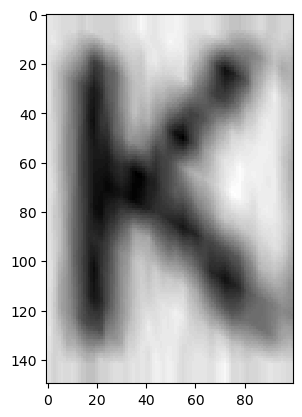

R
0.43137333


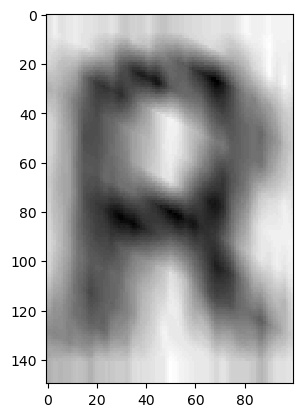

4
0.9649072


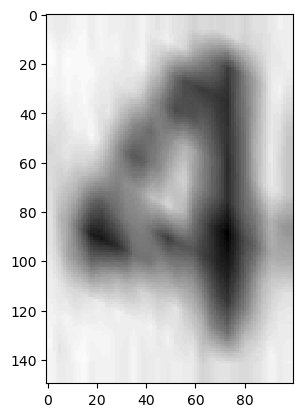

O
0.3502911


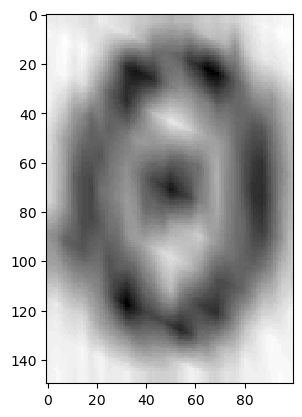

K
0.91432196


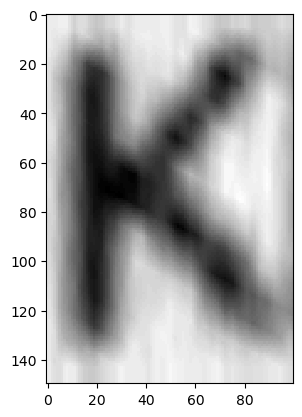

R
0.5422148


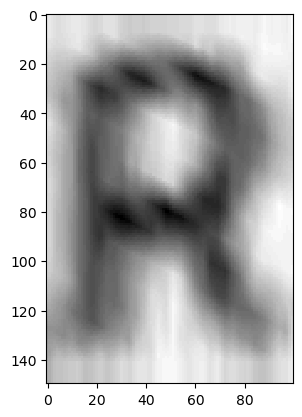

4
0.9306378


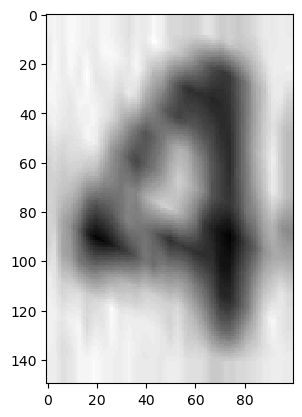

0
0.37392214


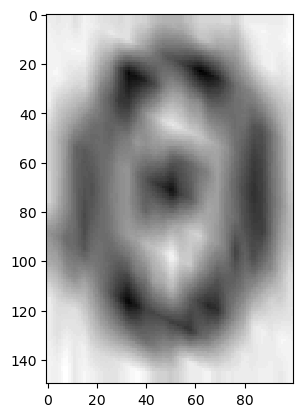

K
0.9408611


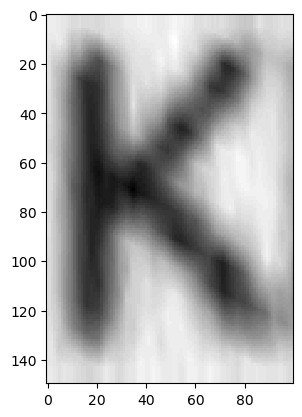

R
0.64465594


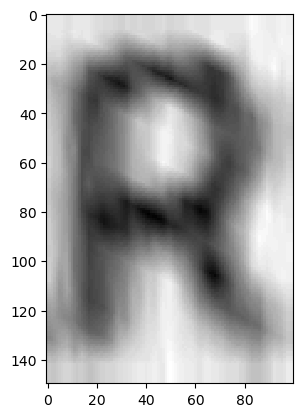

4
0.9709054


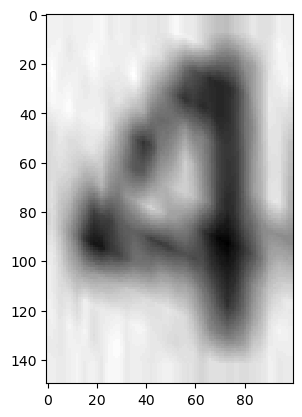

0
0.64593166


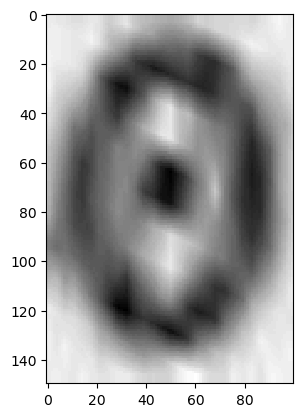

K
0.9557383


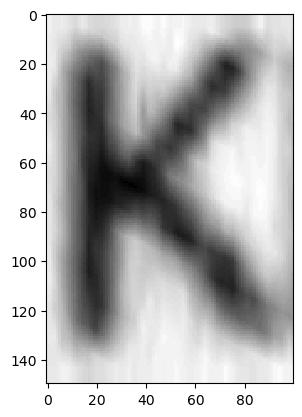

R
0.7619625


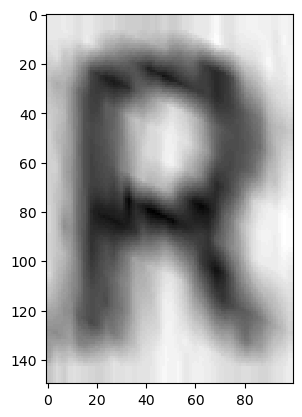

4
0.9752621


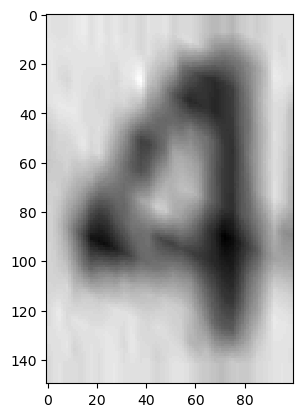

0
0.51706016


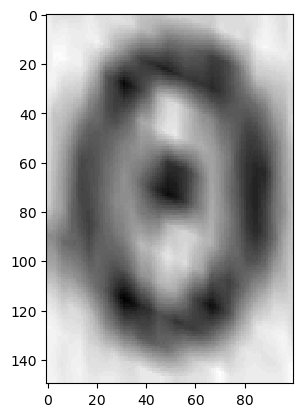

K
0.950601


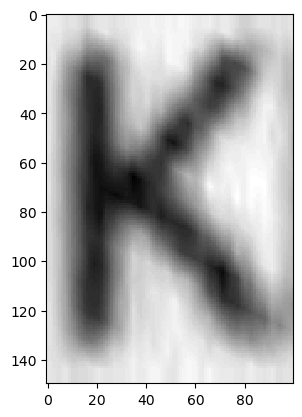

R
0.7677137


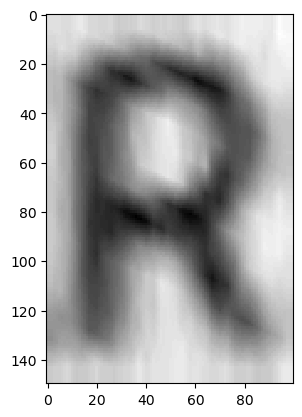

4
0.96679914


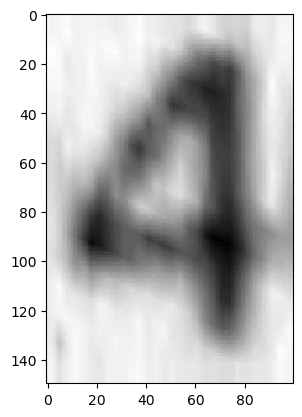

0
0.72824144


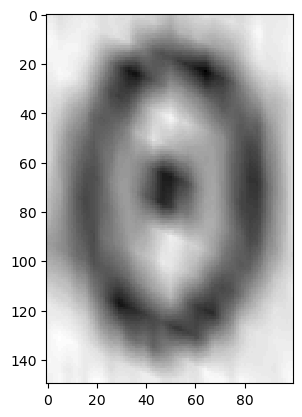

K
0.96704906


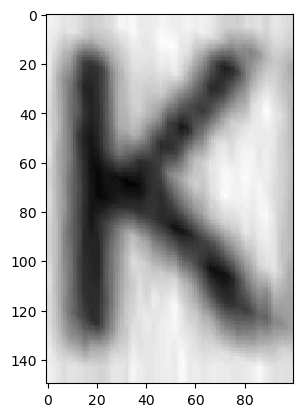

R
0.8614911


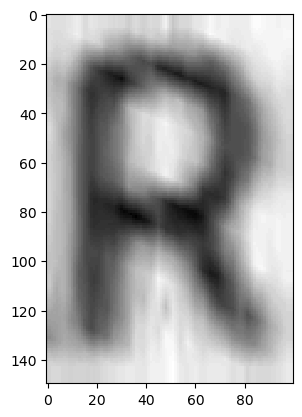

4
0.9812391


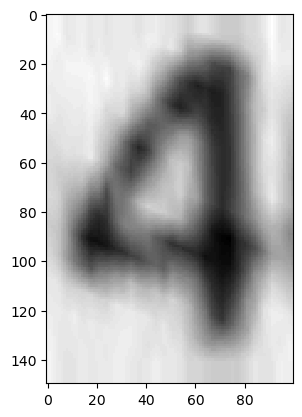

0
0.81995624


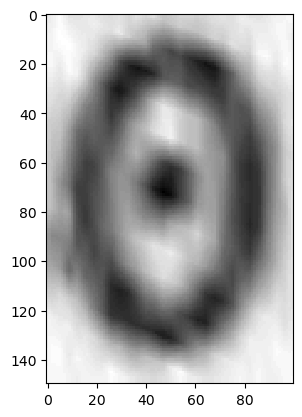

K
0.9613154


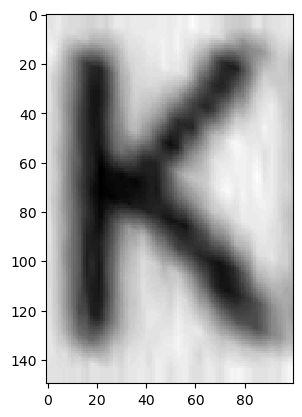

R
0.89748037


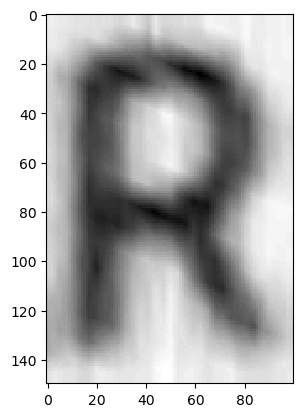

4
0.9845663


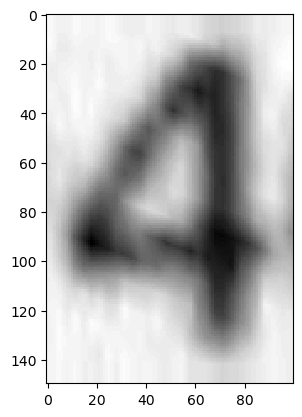

0
0.88661116


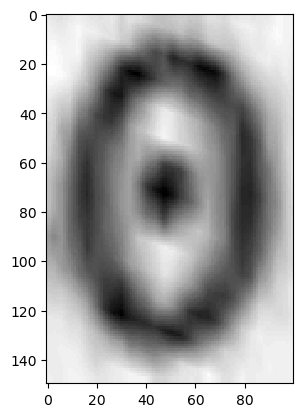

K
0.981723


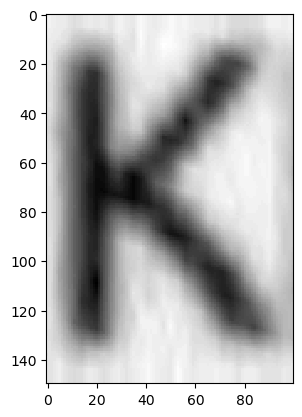

R
0.9385811


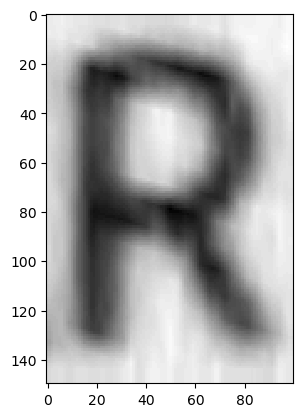

4
0.9895803


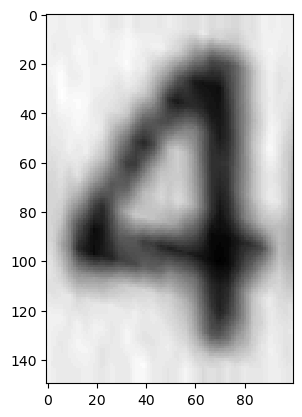

0
0.9194523


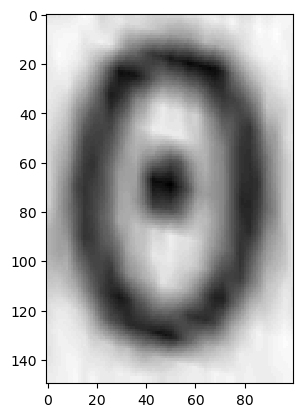

K
0.9828763


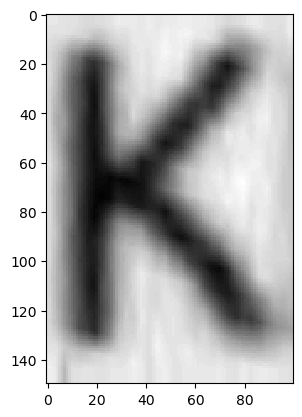

R
0.9674242


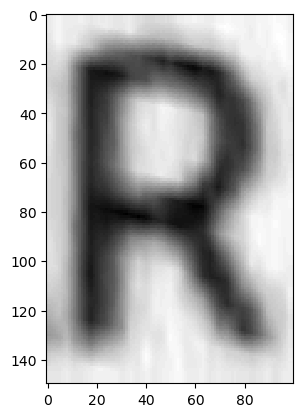

4
0.99470603


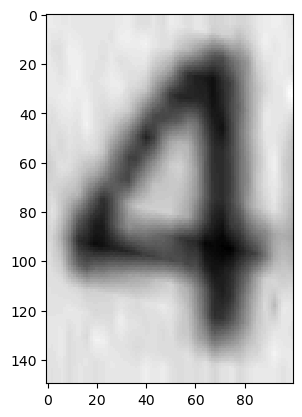

0
0.93151724


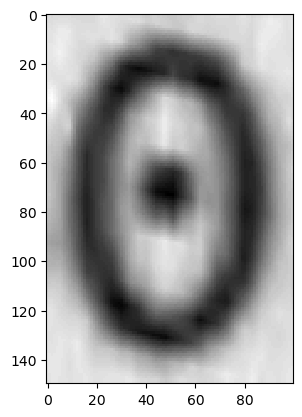

K
0.98889285


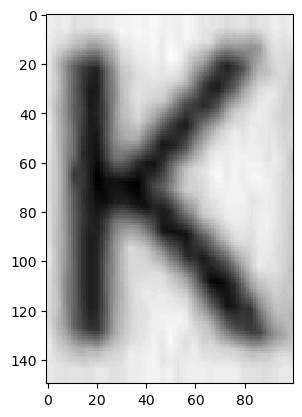

R
0.9755605


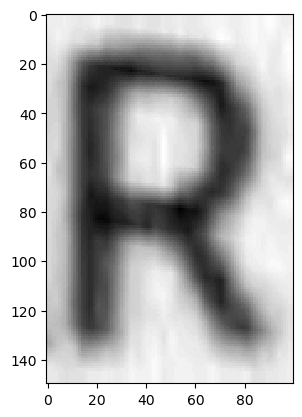

4
0.99649286


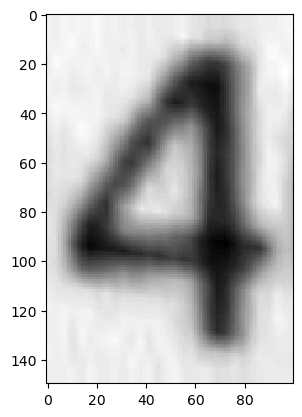

0
0.9596384


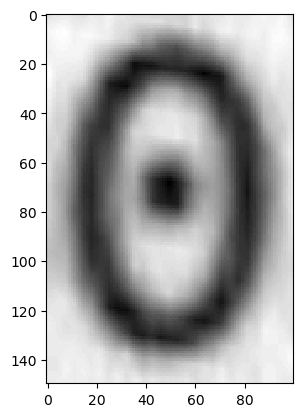

K
0.987655


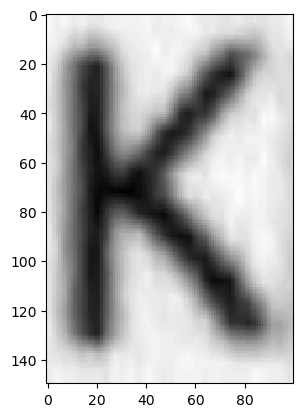

R
0.9790292


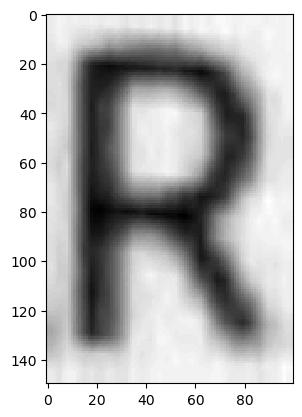

4
0.9976939


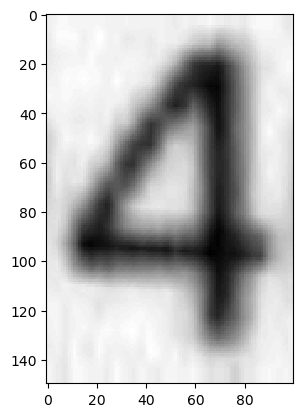

0
0.9673947


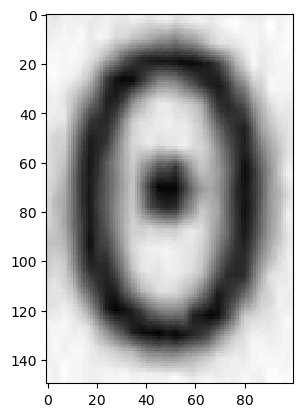

K
0.9876975


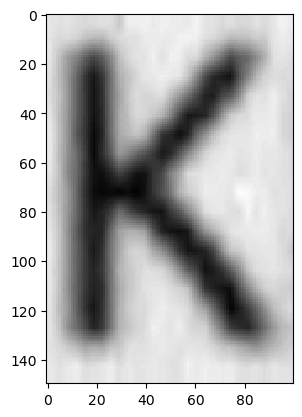

R
0.9862792


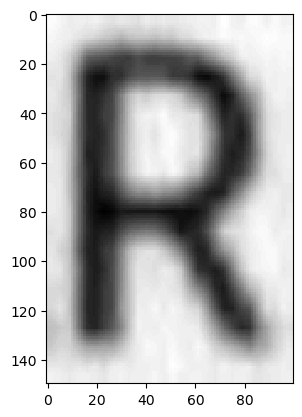

4
0.99726546


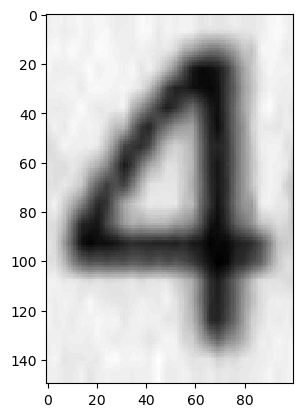

0
0.9830988


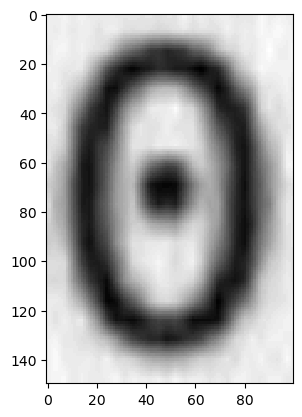

K
0.9870656


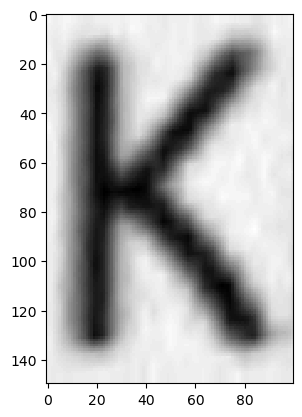

R
0.9931759


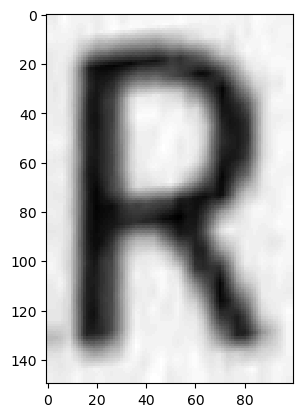

4
0.9992591


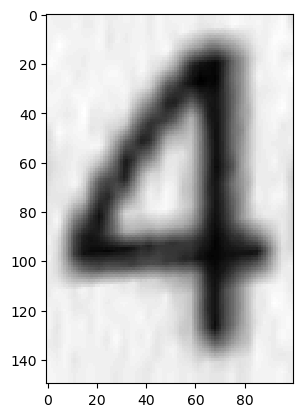

0
0.98942775


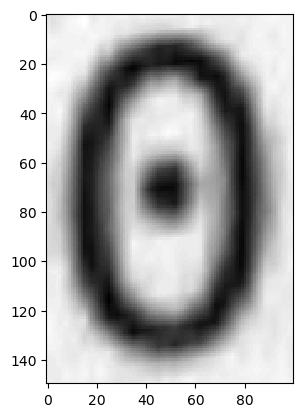

K
0.99577254


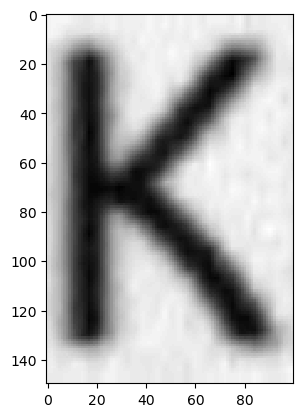

R
0.99836266


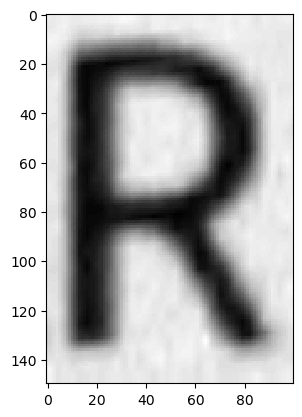

4
0.9997268


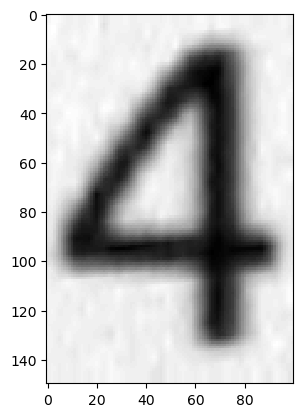

0
0.99389327


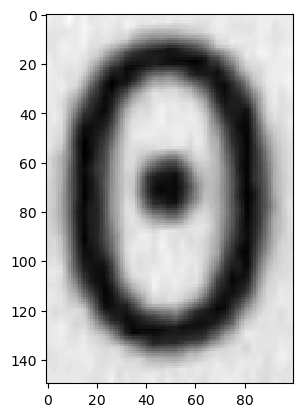

Y
0.4226982


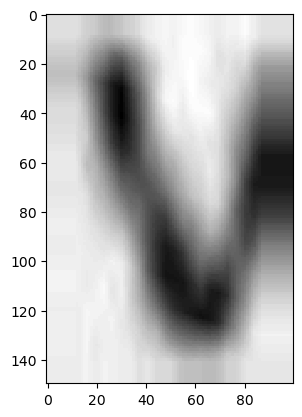

Z
0.82183415


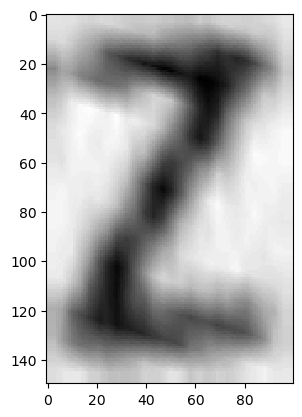

1
0.79755247


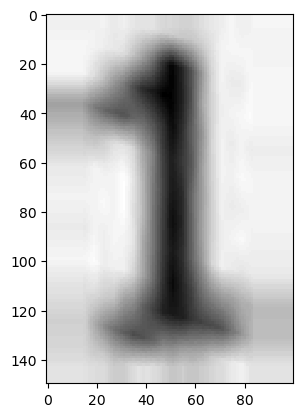

9
0.22694528


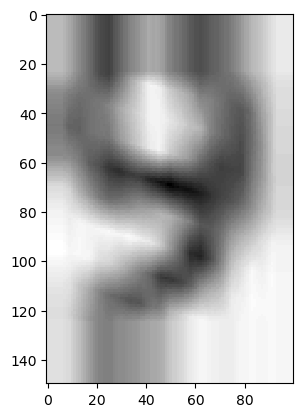

V
0.98260295


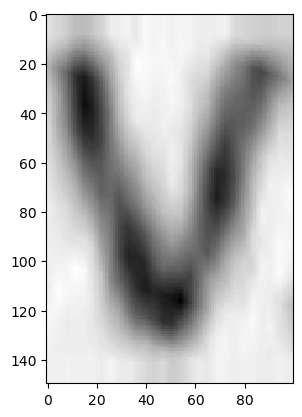

Z
0.84348285


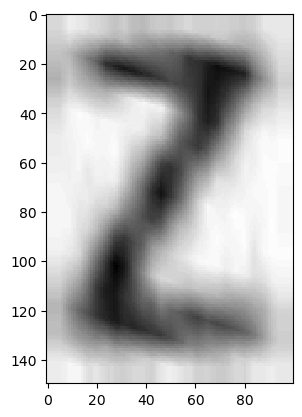

1
0.99619


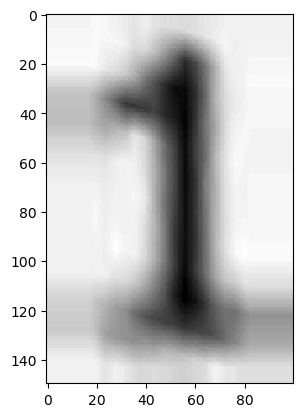

9
0.88884115


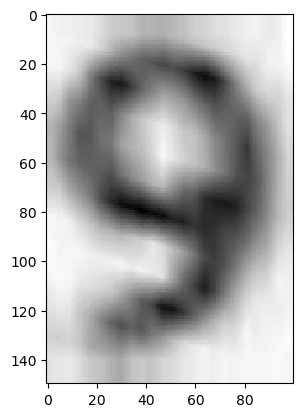

V
0.98715097


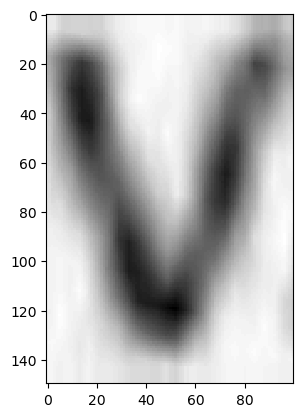

Z
0.8768303


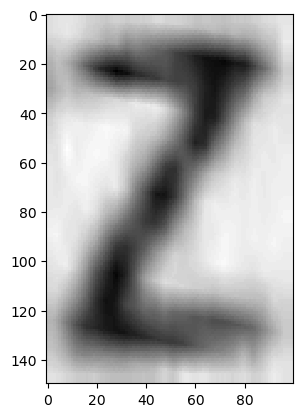

1
0.5250286


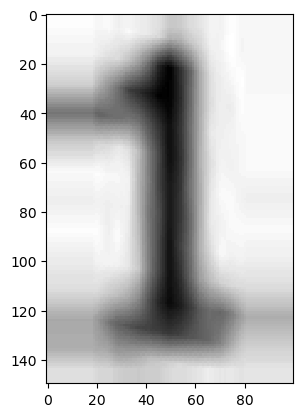

9
0.932539


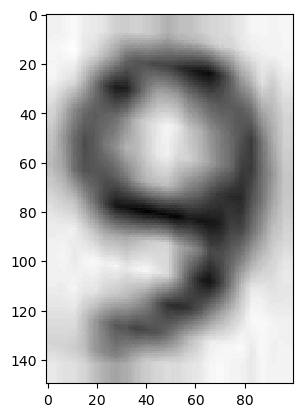

V
0.98842305


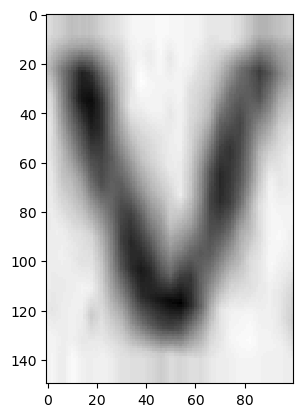

Z
0.8918456


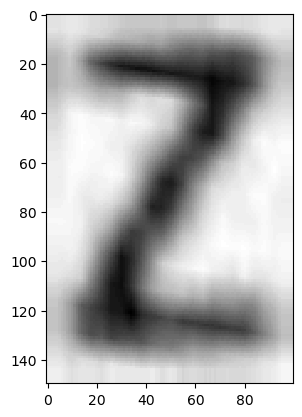

1
0.94319236


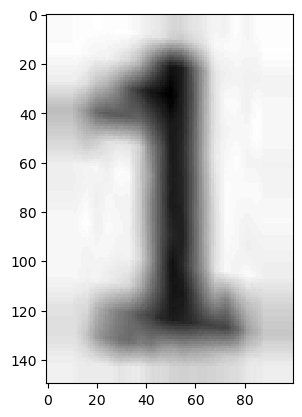

9
0.9395546


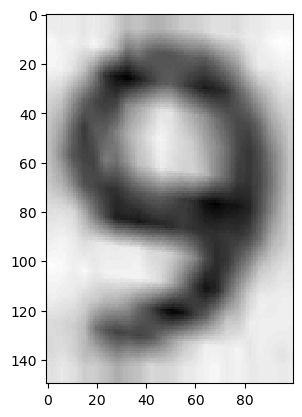

V
0.9891807


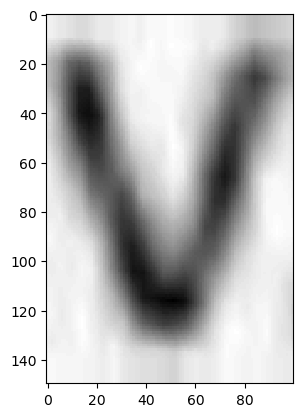

Z
0.8739978


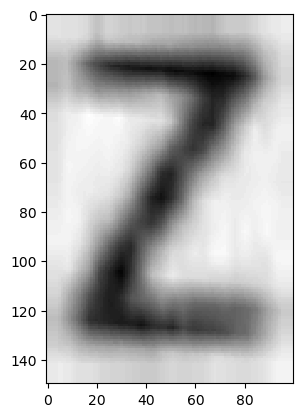

1
0.9916737


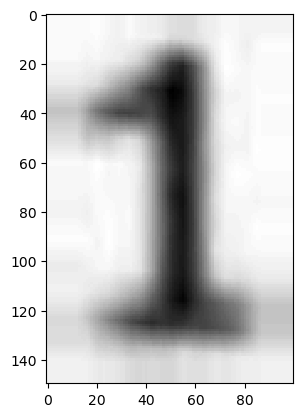

9
0.95618606


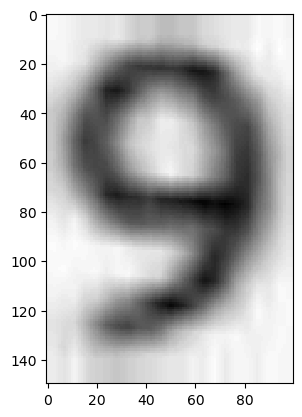

V
0.98724747


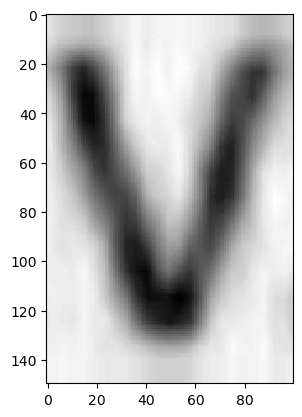

Z
0.9582505


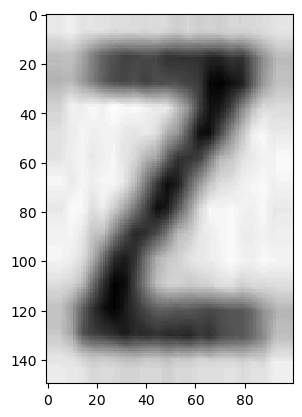

1
0.90540224


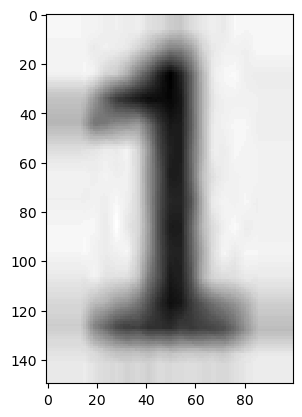

9
0.9667516


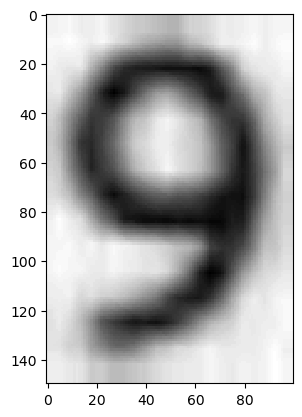

V
0.99500966


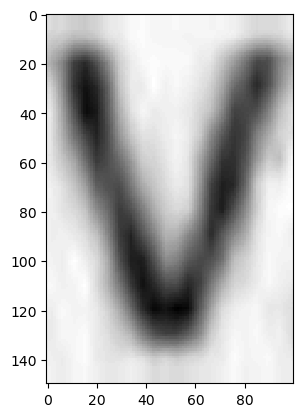

Z
0.97966564


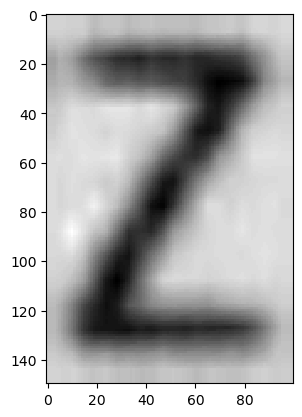

1
0.9770542


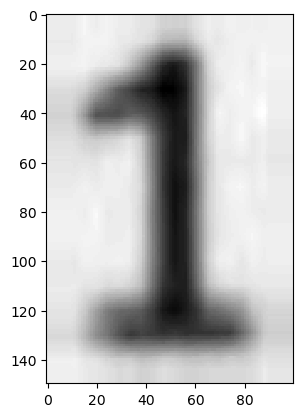

9
0.9815894


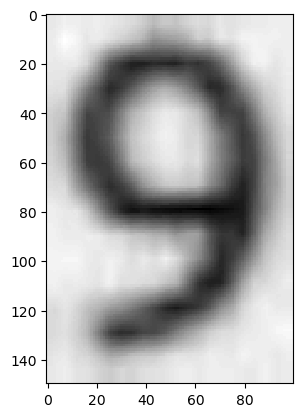

V
0.993565


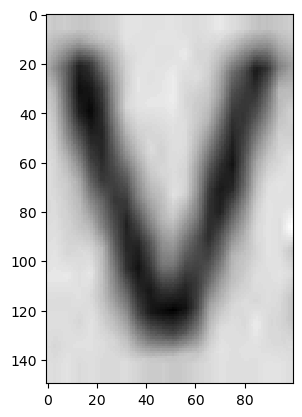

Z
0.9799453


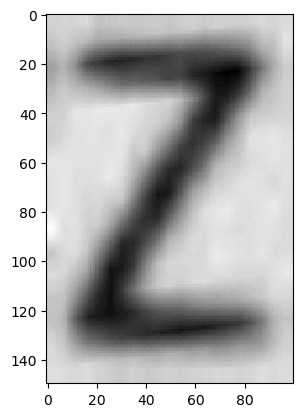

1
0.97042006


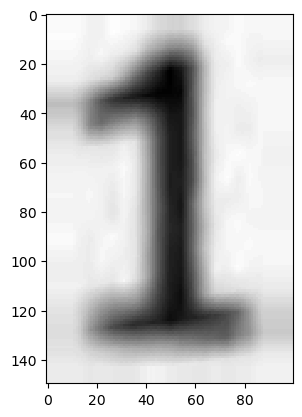

9
0.98583126


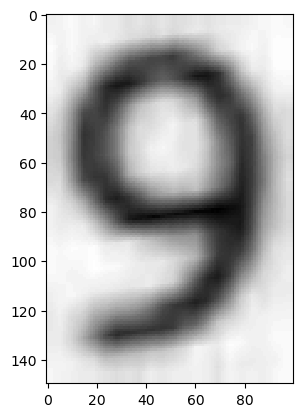

V
0.9973026


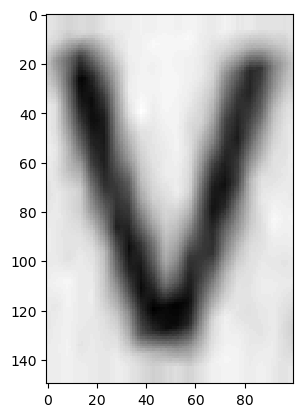

Z
0.9887532


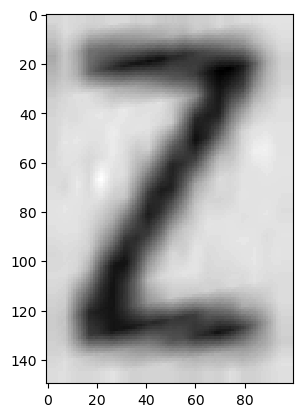

1
0.9794812


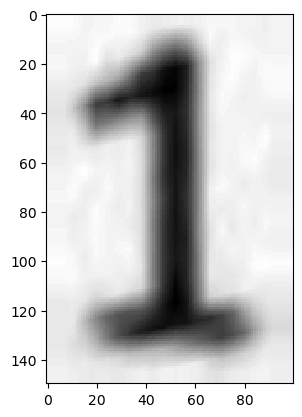

9
0.99329996


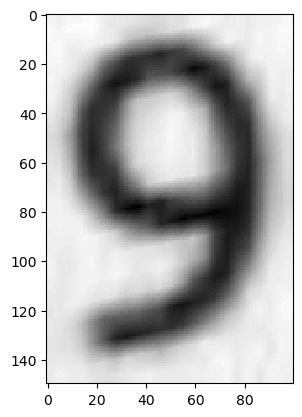

V
0.99978876


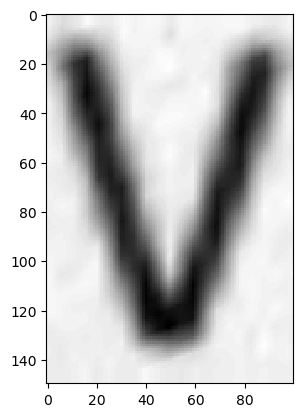

Z
0.9982427


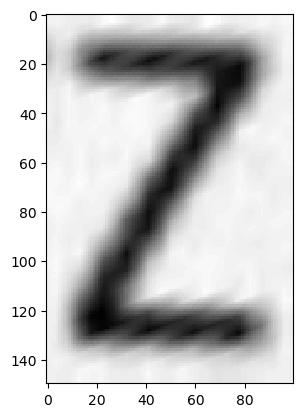

1
0.998817


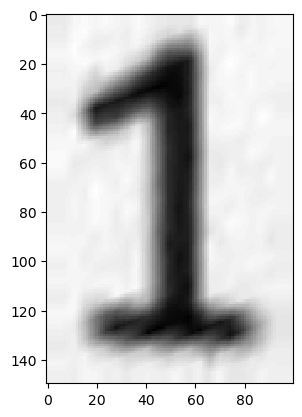

9
0.99805874


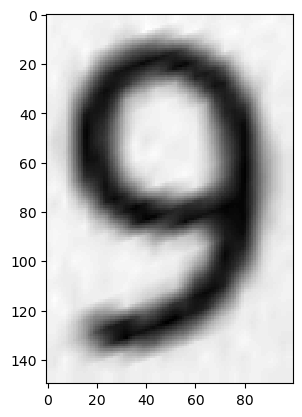

N
0.98157275


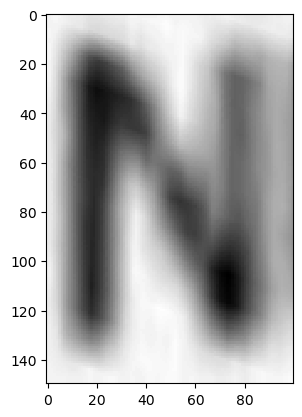

U
0.6499981


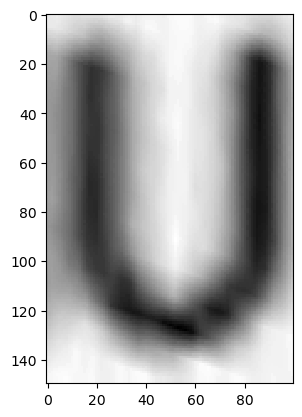

9
0.9799816


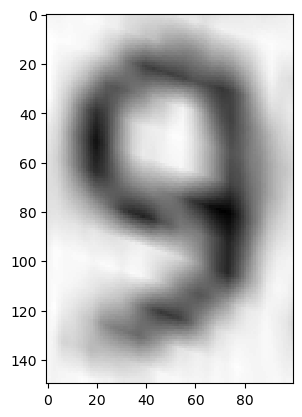

2
0.9267193


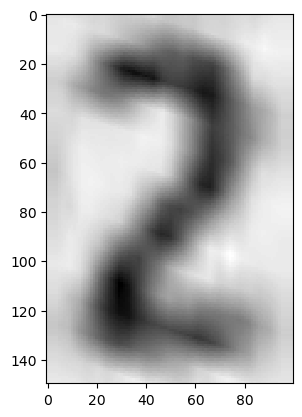

N
0.9953498


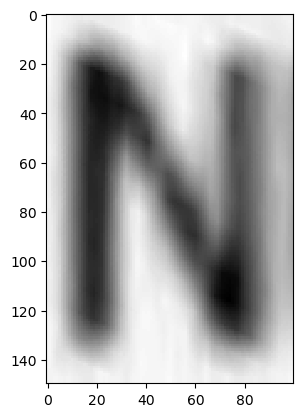

U
0.9360035


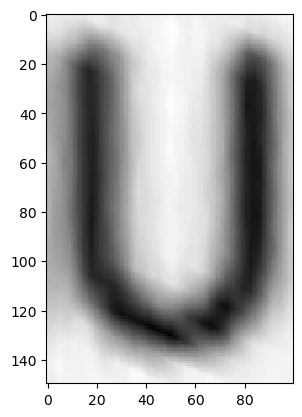

9
0.9960571


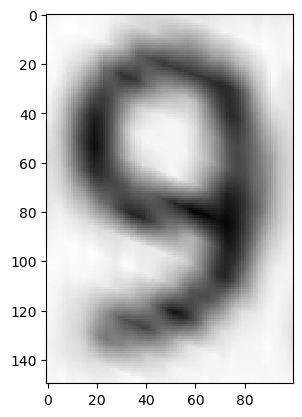

2
0.97398984


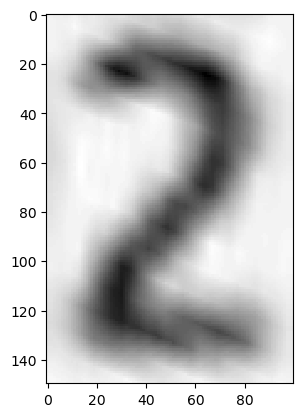

N
0.998415


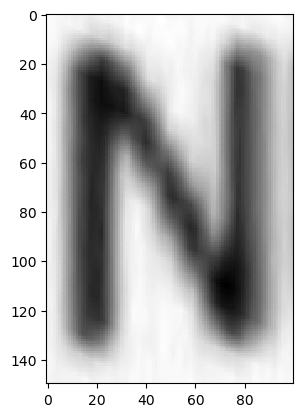

U
0.99629027


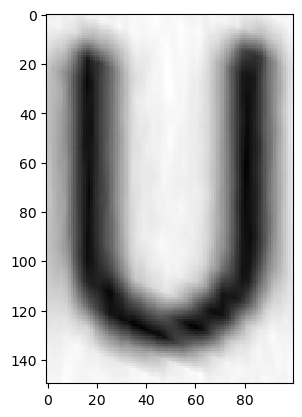

9
0.9988698


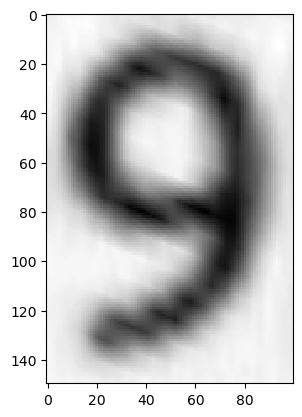

2
0.9940479


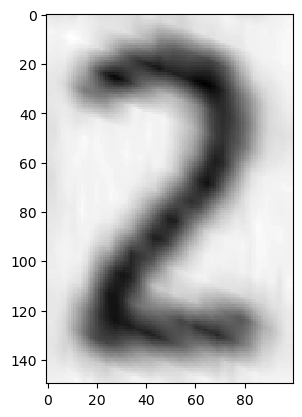

T
0.03892146


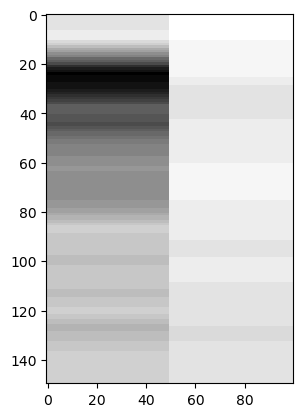

U
0.9762365


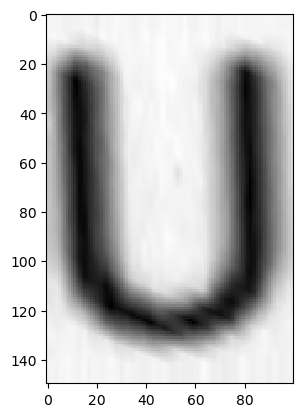

9
0.99966264


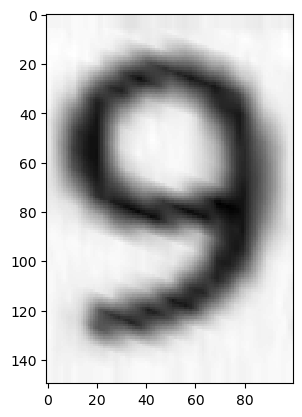

2
0.99967384


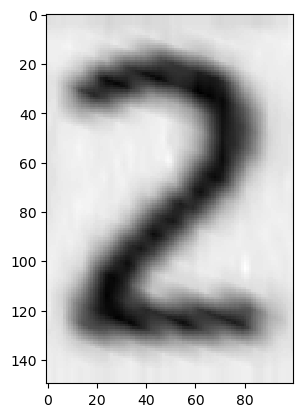

K
0.93772906


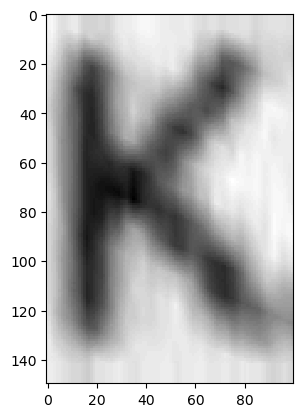

Z
0.67561126


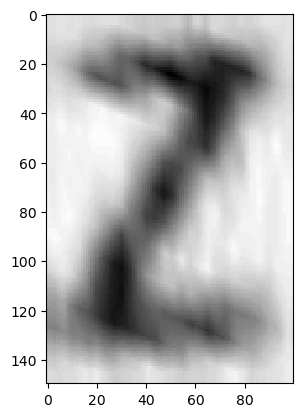

4
0.94424486


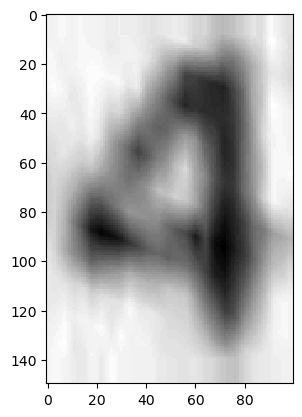

T
0.3740359


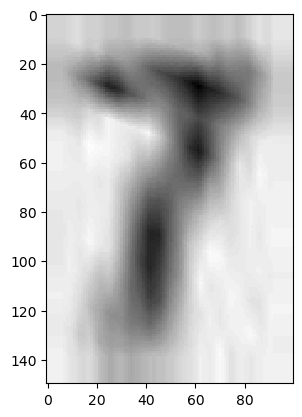

K
0.9574109


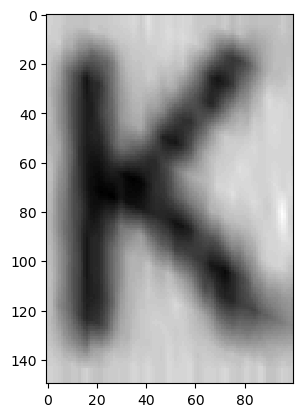

Z
0.76446223


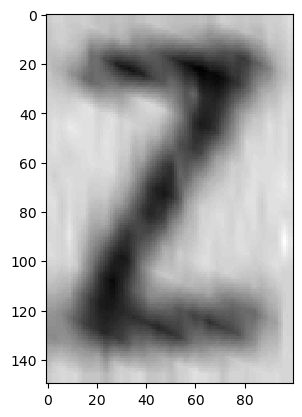

4
0.9796654


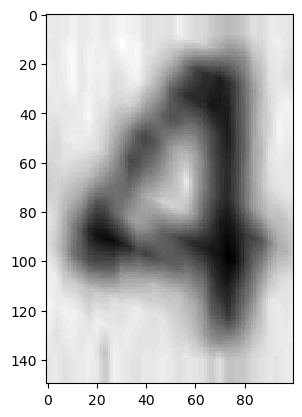

T
0.33354825


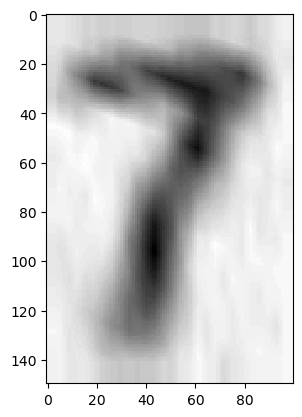

K
0.9757995


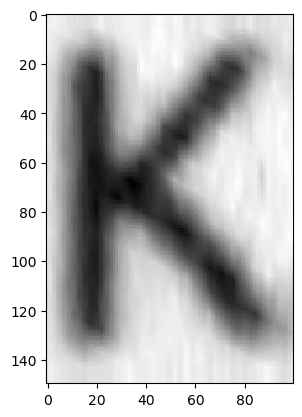

Z
0.90881824


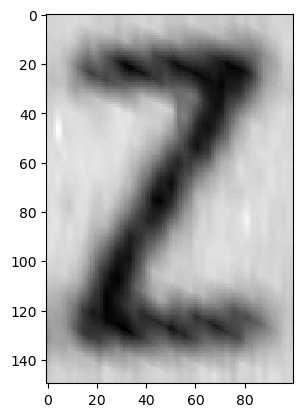

4
0.98948485


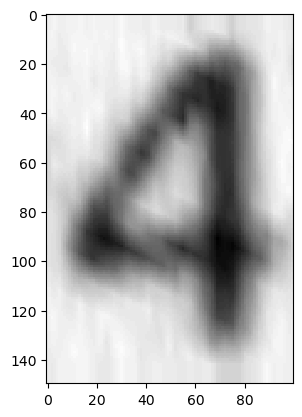

7
0.4706845


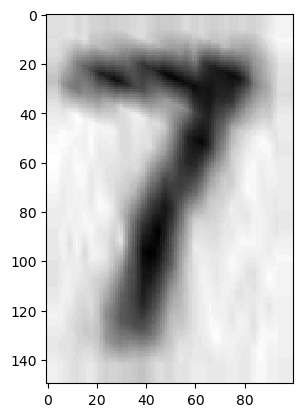

In [13]:
for i in range(pred_syms.shape[0]):


    int_sym = np.argmax(pred[i])
    print(int_to_labels[int_sym])
    print(pred[i].max())

    plt.imshow(plate_syms[i], cmap='gray')
    plt.show()

In [14]:
#conv_model.save('/home/fizzer/ros_ws/src/controller_pkg/cnn_trainer/plate_model_2')

INFO:tensorflow:Assets written to: /home/fizzer/ros_ws/src/controller_pkg/cnn_trainer/plate_model_2/assets


INFO:tensorflow:Assets written to: /home/fizzer/ros_ws/src/controller_pkg/cnn_trainer/plate_model_2/assets


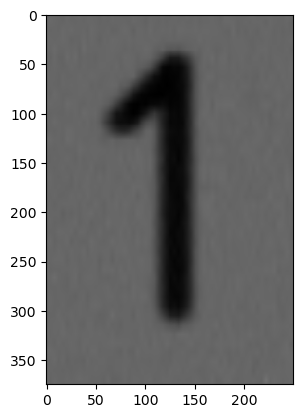

In [5]:
model = tf.keras.models.load_model('/home/fizzer/ros_ws/src/controller_pkg/cnn_trainer/plate_model_2')
pnums = np.load('/home/fizzer/ros_ws/src/controller_pkg/cnn_trainer/plates/pnums.npy', allow_pickle=True)

(1, 150, 100, 1)


'0'

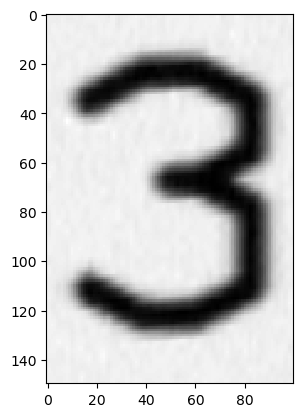

In [26]:
im = cv2.resize(cv2.cvtColor(pnums[117], cv2.COLOR_BGR2GRAY), (100,150))
plt.imshow(im, cmap='gray')

im=im[...,np.newaxis][np.newaxis,...]/255
print(im.shape)

pred = np.argmax(model(im))
label=int_to_labels[pred]
label